In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [54]:
base_ds = pathlib.Path('xray images')

In [55]:
labels = list(set(item.name for item in base_ds.glob('*/*')))
labels = sorted(labels)

In [56]:
labels

['COVID-19', 'Non-COVID', 'Normal']

In [57]:
images = base_ds.glob('**/*.png')
len(list(images))

33920

In [58]:
covid = [items for items in base_ds.glob(f'*/COVID-19/*.png')]
noncovid = [items for items in base_ds.glob(f'*/Non-COVID/*.png')]
normal = [items for items in base_ds.glob(f'*/Normal/*.png')]
classes = [covid, noncovid, normal]

In [59]:
image_count = len(list(base_ds.glob('**/*.png')))
print(f'Total images: {image_count}')
print(f'Total number of classes: {len(labels)}')
count = 0
class_count = []
for label in labels:
    print(f'total {label} images: {len(classes[count])}')
    class_count.append(len(classes[count]))
    count += 1


Total images: 33920
Total number of classes: 3
total COVID-19 images: 11956
total Non-COVID images: 11263
total Normal images: 10701


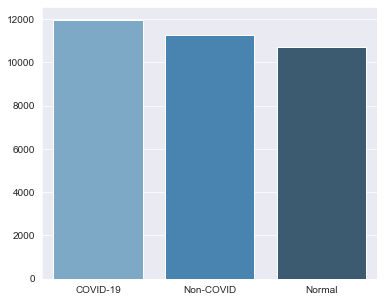

In [60]:
plt.figure(figsize=(6,5))
sns.set_style('darkgrid')
sns.barplot(x=labels, y=class_count, palette="Blues_d")
plt.show()

Image dimensions: (256, 256, 3)


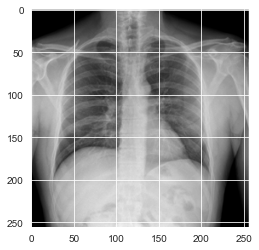

In [10]:
sample_img = cv2.imread('xray images/test/COVID-19/covid_40.png')
plt.imshow(sample_img)
print(f'Image dimensions: {sample_img.shape}')

In [61]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)

In [62]:
datagen = ImageDataGenerator(rescale=1./255)

In [63]:
train_ds = datagen.flow_from_directory(
    'xray images/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    subset = "training",
    class_mode='categorical')

val_ds = datagen.flow_from_directory(
    'xray images/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

test_ds = datagen.flow_from_directory(
    'xray images/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode='categorical',
    shuffle=False)

Found 21715 images belonging to 3 classes.
Found 5417 images belonging to 3 classes.
Found 6788 images belonging to 3 classes.


In [14]:
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [15]:
def plot_train_history_combined(history1, history2):
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='Training Accuracy')
    plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([8,8],
              plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(history1.history['loss'] + history2.history['loss'], label='Training Loss')
    plt.plot(history1.history['val_loss'] + history2.history['val_loss'], label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([8,8],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## VGG16 Model

In [22]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
vgg16.trainable = False
inputs = tf.keras.Input(input_shape)
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

In [23]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 15,243,075
Trainable params: 528,387
Non-trainable params: 14,714,688
_________________________________________

In [20]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_vgg16.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [21]:
history_vgg16 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
170/170 [==============================] - ETA: 0s - loss: 0.7563 - accuracy: 0.6834
Epoch 1: val_accuracy improved from -inf to 0.78291, saving model to saved_models\model_vgg16.hdf5
170/170 [==============================] - 104s 554ms/step - loss: 0.7563 - accuracy: 0.6834 - val_loss: 0.5718 - val_accuracy: 0.7829 - lr: 0.0010
Epoch 2/40
170/170 [==============================] - ETA: 0s - loss: 0.5680 - accuracy: 0.7731
Epoch 2: val_accuracy did not improve from 0.78291
170/170 [==============================] - 61s 360ms/step - loss: 0.5680 - accuracy: 0.7731 - val_loss: 0.5590 - val_accuracy: 0.7825 - lr: 0.0010
Epoch 3/40
170/170 [==============================] - ETA: 0s - loss: 0.5067 - accuracy: 0.7997
Epoch 3: val_accuracy improved from 0.78291 to 0.82924, saving model to saved_models\model_vgg16.hdf5
170/170 [==============================] - 62s 363ms/step - loss: 0.5067 - accuracy: 0.7997 - val_loss: 0.4525 - val_accuracy: 0.8292 - lr: 0.0010
Epoch 4/40
170/170

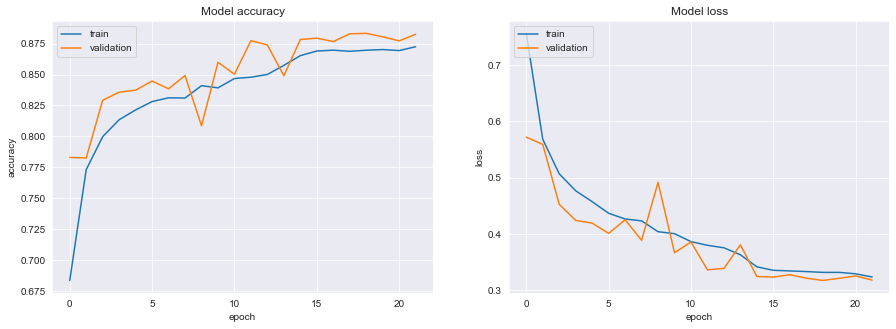

In [23]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')
plot_train_history(history_vgg16)

In [24]:
vgg16.trainable = True
model_vgg16.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
history2 = model_vgg16.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
340/340 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8814
Epoch 1: val_accuracy improved from 0.88333 to 0.90862, saving model to saved_models\model_vgg16.hdf5
340/340 [==============================] - 162s 461ms/step - loss: 0.3040 - accuracy: 0.8814 - val_loss: 0.2359 - val_accuracy: 0.9086 - lr: 1.0000e-05
Epoch 2/40
340/340 [==============================] - ETA: 0s - loss: 0.2135 - accuracy: 0.9163
Epoch 2: val_accuracy improved from 0.90862 to 0.91748, saving model to saved_models\model_vgg16.hdf5
340/340 [==============================] - 156s 458ms/step - loss: 0.2135 - accuracy: 0.9163 - val_loss: 0.2223 - val_accuracy: 0.9175 - lr: 1.0000e-05
Epoch 3/40
340/340 [==============================] - ETA: 0s - loss: 0.1791 - accuracy: 0.9281
Epoch 3: val_accuracy improved from 0.91748 to 0.92800, saving model to saved_models\model_vgg16.hdf5
340/340 [==============================] - 158s 464ms/step - loss: 0.1791 - accuracy: 0.9281 - val_los

In [25]:
model_vgg16.load_weights('saved_models/model_vgg16.hdf5')

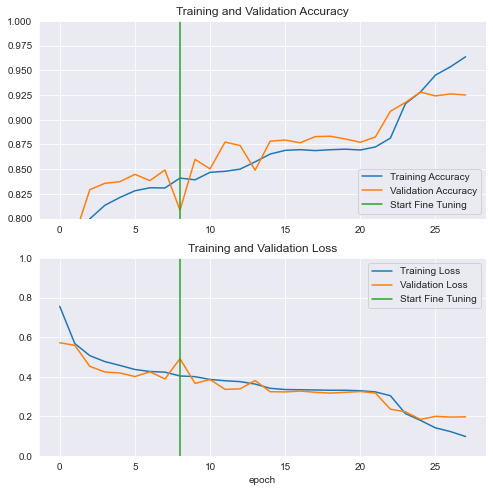

In [35]:
plot_train_history_combined(history_vgg16, history2)

In [26]:
score_vgg16 = model_vgg16.evaluate(test_ds, verbose=1)

107/107 [==============================] - 18s 149ms/step - loss: 0.1737 - accuracy: 0.9352


## ResNet50 Model

In [64]:
resnet = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet'
)
for layer in resnet.layers[:143]:
    layers.trainable=False
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Dropout(rate=0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model_resnet50 = tf.keras.Model(resnet.input, x)
model_resnet50.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
model_resnet50.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet50.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_5[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         

                                                                                                  
 conv2_block2_add (Add)         (None, None, None,   0           ['conv2_block1_out[0][0]',       
                                256)                              'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, None, None,   0           ['conv2_block2_add[0][0]']       
                                256)                                                              
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, None, None,   16448       ['conv2_block2_out[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_2_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, None, None,   0          ['conv3_block2_2_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, None, None,   66048       ['conv3_block2_2_relu[0][0]']    
                                512)                                                              
          

 conv4_block1_1_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_1_conv[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, None, None,   0          ['conv4_block1_1_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, None, None,   590080      ['conv4_block1_1_relu[0][0]']    
                                256)                                                              
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, None, None,   1024       ['conv4_block1_2_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       1024)                                                             
                                                                                                  
 conv4_block3_add (Add)         (None, None, None,   0           ['conv4_block2_out[0][0]',       
                                1024)                             'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, None, None,   0           ['conv4_block3_add[0][0]']       
                                1024)                                                             
                                                                                                  
 conv4_blo

 ization)                       256)                                                              
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, None, None,   0          ['conv4_block6_2_bn[0][0]']      
 n)                             256)                                                              
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, None, None,   263168      ['conv4_block6_2_relu[0][0]']    
                                1024)                                                             
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, None, None,   4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       1024)                                                             
          

 conv5_block3_1_conv (Conv2D)   (None, None, None,   1049088     ['conv5_block2_out[0][0]']       
                                512)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   2048       ['conv5_block3_1_conv[0][0]']    
 ization)                       512)                                                              
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, None, None,   0          ['conv5_block3_1_bn[0][0]']      
 n)                             512)                                                              
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, None, None,   2359808     ['conv5_block3_1_relu[0][0]']    
          

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_resnet50.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [27]:
history1_resnet = model_resnet50.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
679/679 [==============================] - ETA: 0s - loss: 0.4461 - accuracy: 0.8322
Epoch 1: val_accuracy improved from -inf to 0.35905, saving model to saved_models\model_resnet50.hdf5
679/679 [==============================] - 136s 199ms/step - loss: 0.4461 - accuracy: 0.8322 - val_loss: 3.7378 - val_accuracy: 0.3591 - lr: 0.0010
Epoch 2/40
679/679 [==============================] - ETA: 0s - loss: 0.2964 - accuracy: 0.8871
Epoch 2: val_accuracy improved from 0.35905 to 0.58058, saving model to saved_models\model_resnet50.hdf5
679/679 [==============================] - 129s 191ms/step - loss: 0.2964 - accuracy: 0.8871 - val_loss: 1.3390 - val_accuracy: 0.5806 - lr: 0.0010
Epoch 3/40
679/679 [==============================] - ETA: 0s - loss: 0.2592 - accuracy: 0.9017
Epoch 3: val_accuracy improved from 0.58058 to 0.68950, saving model to saved_models\model_resnet50.hdf5
679/679 [==============================] - 132s 194ms/step - loss: 0.2592 - accuracy: 0.9017 - val_loss:

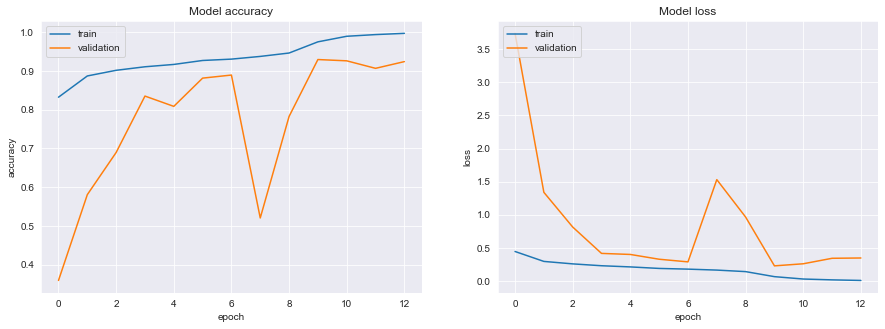

In [28]:
model_resnet50.load_weights('saved_models/model_resnet50.hdf5')
plot_train_history(history1_resnet)

In [65]:
resnet.trainable = True
model_resnet50.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
history2_resnet = model_resnet50.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
679/679 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9909
Epoch 1: val_accuracy improved from 0.92948 to 0.93687, saving model to saved_models\model_resnet50.hdf5
679/679 [==============================] - 132s 190ms/step - loss: 0.0295 - accuracy: 0.9909 - val_loss: 0.2254 - val_accuracy: 0.9369 - lr: 1.0000e-05
Epoch 2/40
679/679 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9917
Epoch 2: val_accuracy did not improve from 0.93687
679/679 [==============================] - 131s 193ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.2406 - val_accuracy: 0.9356 - lr: 1.0000e-05
Epoch 3/40
679/679 [==============================] - ETA: 0s - loss: 0.0197 - accuracy: 0.9938
Epoch 3: val_accuracy did not improve from 0.93687
679/679 [==============================] - 126s 186ms/step - loss: 0.0197 - accuracy: 0.9938 - val_loss: 0.2508 - val_accuracy: 0.9367 - lr: 1.0000e-05
Epoch 4/40
679/679 [=============================

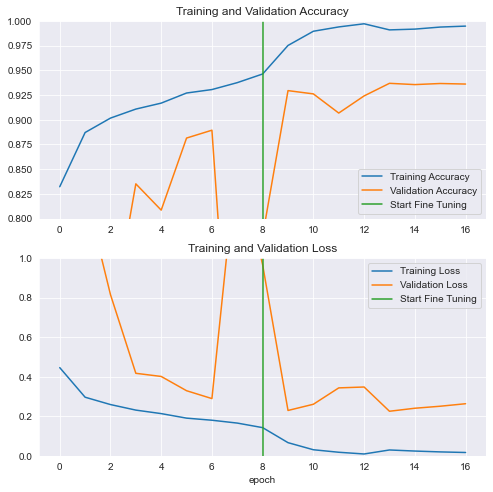

In [31]:
model_resnet50.load_weights('saved_models/model_resnet50.hdf5')
plot_train_history_combined(history1_resnet, history2_resnet)

In [31]:
score_resnet50 = model_resnet50.evaluate(test_ds, verbose=1)

107/107 [==============================] - 13s 109ms/step - loss: 0.1682 - accuracy: 0.9526


## InceptionV3

In [17]:
inception = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
inception.trainable = False
inputs = tf.keras.Input(input_shape)
x = inception(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)
model_inceptionv3 = tf.keras.Model(inputs, x)

In [18]:
model_inceptionv3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_inceptionv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 23,904,035
Trainable params: 2,101,251
Non-trainable params: 21,802,784
_________________________________________

In [40]:
checkpointer = ModelCheckpoint(filepath='saved_models/model_inceptionv3.hdf5', 
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [41]:
history1_inception = model_inceptionv3.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
340/340 [==============================] - ETA: 0s - loss: 0.7308 - accuracy: 0.7098
Epoch 1: val_accuracy improved from -inf to 0.77164, saving model to saved_models\model_inceptionv3.hdf5
340/340 [==============================] - 44s 120ms/step - loss: 0.7308 - accuracy: 0.7098 - val_loss: 0.5582 - val_accuracy: 0.7716 - lr: 0.0010
Epoch 2/40
340/340 [==============================] - ETA: 0s - loss: 0.5626 - accuracy: 0.7665
Epoch 2: val_accuracy improved from 0.77164 to 0.81133, saving model to saved_models\model_inceptionv3.hdf5
340/340 [==============================] - 39s 116ms/step - loss: 0.5626 - accuracy: 0.7665 - val_loss: 0.4757 - val_accuracy: 0.8113 - lr: 0.0010
Epoch 3/40
340/340 [==============================] - ETA: 0s - loss: 0.5155 - accuracy: 0.7878
Epoch 3: val_accuracy improved from 0.81133 to 0.81613, saving model to saved_models\model_inceptionv3.hdf5
340/340 [==============================] - 38s 112ms/step - loss: 0.5155 - accuracy: 0.7878 - val

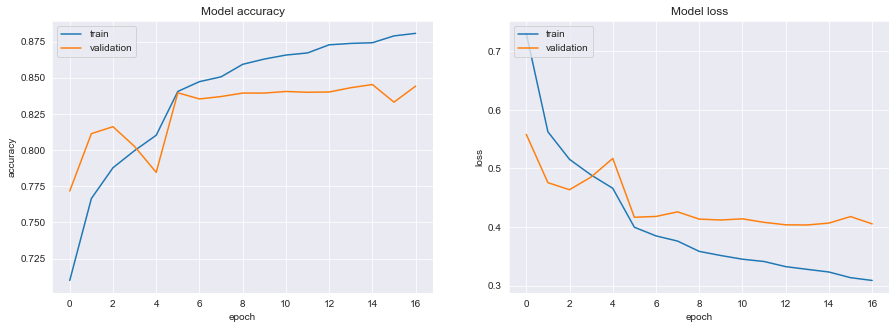

In [43]:
model_inceptionv3.load_weights('saved_models/model_inceptionv3.hdf5')
plot_train_history(history1_inception)

In [19]:
inception.trainable=True

model_inceptionv3.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy', metrics=['accuracy'])

model_inceptionv3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 23,904,035
Trainable params: 23,869,603
Non-trainable params: 34,432
____________________________________________

In [46]:
history2_inception = model_inceptionv3.fit(train_ds, epochs = 40, validation_data = val_ds, callbacks=callbacks)

Epoch 1/40
340/340 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.8782
Epoch 1: val_accuracy improved from 0.84530 to 0.90438, saving model to saved_models\model_inceptionv3.hdf5
340/340 [==============================] - 96s 266ms/step - loss: 0.3105 - accuracy: 0.8782 - val_loss: 0.2568 - val_accuracy: 0.9044 - lr: 1.0000e-05
Epoch 2/40
340/340 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9283
Epoch 2: val_accuracy improved from 0.90438 to 0.91564, saving model to saved_models\model_inceptionv3.hdf5
340/340 [==============================] - 88s 260ms/step - loss: 0.1860 - accuracy: 0.9283 - val_loss: 0.2252 - val_accuracy: 0.9156 - lr: 1.0000e-05
Epoch 3/40
340/340 [==============================] - ETA: 0s - loss: 0.1285 - accuracy: 0.9522
Epoch 3: val_accuracy improved from 0.91564 to 0.91914, saving model to saved_models\model_inceptionv3.hdf5
340/340 [==============================] - 87s 257ms/step - loss: 0.1285 - accuracy: 0

In [20]:
model_inceptionv3.load_weights('saved_models/model_inceptionv3.hdf5')

In [21]:
score_inceptionv3 = model_inceptionv3.evaluate(test_ds, verbose=1)

107/107 [==============================] - 15s 105ms/step - loss: 0.2057 - accuracy: 0.9316


In [32]:
print(f'VGG16 Loss: {score_vgg16[0]}, Accuracy: {score_vgg16[1]*100}')
print(f'ResNet50 Loss: {score_resnet50[0]}, Accuracy: {score_resnet50[1]*100}')
print(f'InceptionV3 Loss: {score_inceptionv3[0]}, Accuracy: {score_inceptionv3[1]*100}')

VGG16 Loss: 0.1736888438463211, Accuracy: 93.51797103881836
ResNet50 Loss: 0.16817639768123627, Accuracy: 95.25633454322815
InceptionV3 Loss: 0.20569166541099548, Accuracy: 93.1644082069397


## Evaluation

In [66]:
model_resnet50.load_weights('saved_models/model_resnet50.hdf5')

In [67]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model_resnet50.predict(test_ds)
y_pred = np.argmax(Y_pred, axis=1)

In [70]:
test_ds.class_indices = ['COVID-19', 'Non-COVID', 'Normal']

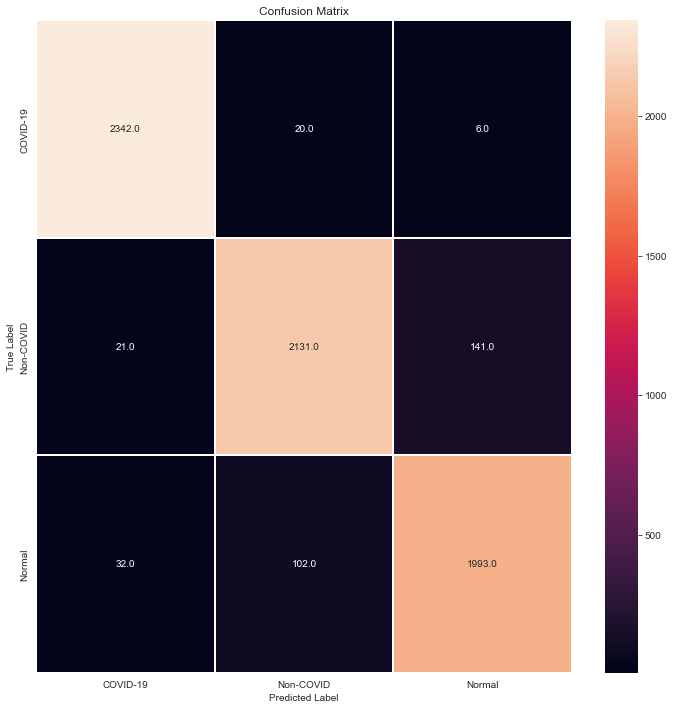

In [71]:
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(labels)
plt.title("Confusion Matrix")
plt.show()

In [75]:
report1 = classification_report(test_ds.classes, y_pred, target_names=labels, output_dict=True)
df1 = pd.DataFrame(report1).transpose()
df1

,precision,recall,f1-score,support
COVID-19,0.989020,0.977871,0.983414,2395.000000
Non-COVID,0.929350,0.945850,0.937527,2253.000000
Normal,0.937000,0.931308,0.934146,2140.000000
accuracy,0.952563,0.952563,0.952563,0.952563
macro avg,0.951790,0.951676,0.951696,6788.000000
weighted avg,0.952815,0.952563,0.952651,6788.000000


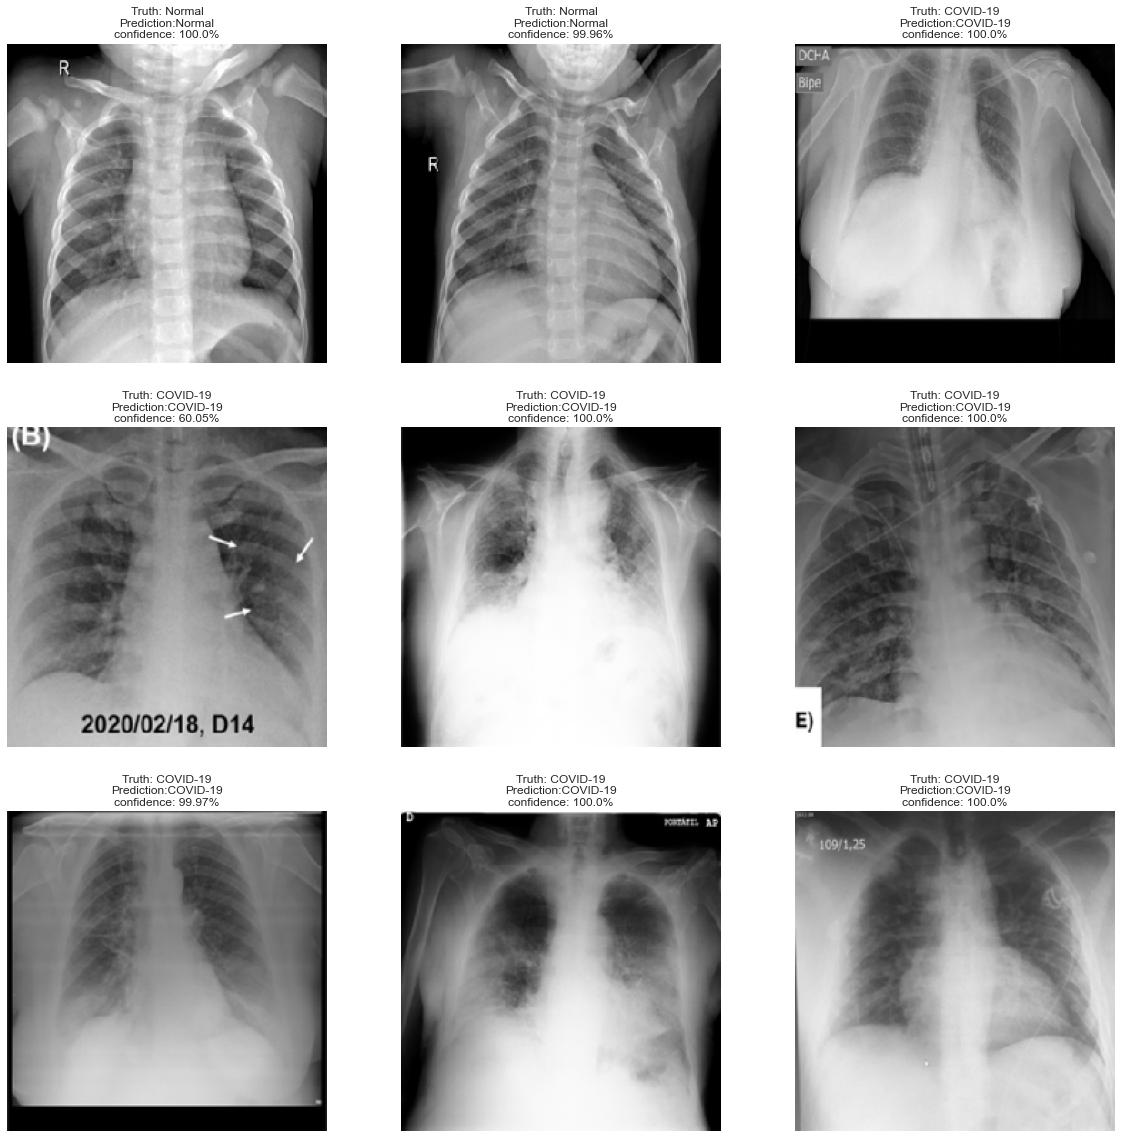

In [103]:
plt.figure(figsize=(20, 20))
for i in range(9):
    x, label= test_ds.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    normalized = tf.expand_dims(x[i], 0)
    predict = model_resnet50.predict(normalized)
    score = tf.nn.softmax(predict[0])
    index = np.argmax(score)
    score_label = labels[index]
    confidence_score = (predict[0][index])*100
    confidence_score = round(confidence_score, 2)
    plt.title(f'Truth: {labels[result[0][0]]}\nPrediction:{score_label}\nconfidence: {confidence_score}%')
    plt.axis(False)